## Controlling Synthetic Data Generation from Physical Space
* Uses Generative Adeversarial Networks + Support Vector Machines

In [18]:
# download data
!wget 'https://www.dropbox.com/scl/fi/u73po4g7bmggz0ugzichb/embeddings_dict_SHARP_mag_proj_False_odim_100_constrained.p?rlkey=h18vwr9liwc4mliqphtedbv4u&st=je18fen4&dl=0'
!wget 'https://www.dropbox.com/scl/fi/oy65bdrqir6ra4sfchru9/index_sharps.csv?rlkey=vg0r37bbg1eaus4pruio1cg1v&st=o1y8bh5g&dl=0'
!mv 'embeddings_dict_SHARP_mag_proj_False_odim_100_constrained.p?rlkey=h18vwr9liwc4mliqphtedbv4u&st=je18fen4&dl=0' 'data/embeddings_dict_SHARP_mag_proj_False_odim_100_constrained.p'
!mv 'index_sharps.csv?rlkey=vg0r37bbg1eaus4pruio1cg1v&st=o1y8bh5g&dl=0' 'data/index_sharps.csv'

--2024-12-14 16:26:00--  https://www.dropbox.com/scl/fi/u73po4g7bmggz0ugzichb/embeddings_dict_SHARP_mag_proj_False_odim_100_constrained.p?rlkey=h18vwr9liwc4mliqphtedbv4u&st=je18fen4&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uce02ca5ba59b9e6966c60c6823e.dl.dropboxusercontent.com/cd/0/inline/CgRjw-iZoE7YgYEx-X6c5aVG7_hfLZisw2CVEXNvXrep8Kqi75ZTetWYMk9WRwFYzEjc-R0ubYiJYYvSPnjDNUtl3Ln96lm-eKhD28g-FzftZ5Z9TGfFASqiYpDxDlJxvbOJyX5OGYyCkZkkYu-EnN0h/file# [following]
--2024-12-14 16:26:00--  https://uce02ca5ba59b9e6966c60c6823e.dl.dropboxusercontent.com/cd/0/inline/CgRjw-iZoE7YgYEx-X6c5aVG7_hfLZisw2CVEXNvXrep8Kqi75ZTetWYMk9WRwFYzEjc-R0ubYiJYYvSPnjDNUtl3Ln96lm-eKhD28g-FzftZ5Z9TGfFASqiYpDxDlJxvbOJyX5OGYyCkZkkYu-EnN0h/file
Resolving uce02ca5ba59b9e6966c60c6823e.dl.dropboxusercontent.com (uce02ca5ba59b9e

162.125.8.15, 2620:100:601b:15::a27d:80f
Connecting to uce02ca5ba59b9e6966c60c6823e.dl.dropboxusercontent.com (uce02ca5ba59b9e6966c60c6823e.dl.dropboxusercontent.com)|162.125.8.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105341882 (100M) [text/plain]
Saving to: ‘embeddings_dict_SHARP_mag_proj_False_odim_100_constrained.p?rlkey=h18vwr9liwc4mliqphtedbv4u&st=je18fen4&dl=0’

embeddings_dict_SHA 100%[===================>] 100.46M  90.7MB/s    in 1.1s    

2024-12-14 16:26:07 (90.7 MB/s) - ‘embeddings_dict_SHARP_mag_proj_False_odim_100_constrained.p?rlkey=h18vwr9liwc4mliqphtedbv4u&st=je18fen4&dl=0’ saved [105341882/105341882]

--2024-12-14 16:26:08--  https://www.dropbox.com/scl/fi/oy65bdrqir6ra4sfchru9/index_sharps.csv?rlkey=vg0r37bbg1eaus4pruio1cg1v&st=o1y8bh5g&dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.8.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.8.18|:443... connected.
HTTP request sent, awaitin

In [20]:
import torch
from dataset import SHARPdataset
import matplotlib.pyplot as plt
from gan import GAN
import numpy as np
from skimage.morphology import binary_dilation, binary_erosion
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp
from PIL import Image
import torchvision.transforms.functional as functional
import cv2
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import sys
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.offsetbox as osb
from matplotlib import rcParams as rcp
import torchvision.transforms.functional as functional
from PIL import Image
import torch
from simsiam import load_model
from sdo_augmentation.augmentation import Augmentations
from sdo_augmentation.augmentation_list import AugmentationList
import h5py
from PIL import Image
from utils import * 
from scipy import stats

In [21]:
#Load trained GAN from 81st epoch 
ep = '81'
name = f'GAN_sharp_experiment_ld_100_bs_32_lr_0.0005_stride_1_crop_False_arch_simple_epoch={ep}.ckpt'
MODEL_DIR = './models/'
pl_module = GAN.load_from_checkpoint(MODEL_DIR + name)
device = 'cuda:1'
pl_module.to(device)

GAN(
  (generator): Generator(
    (bl): SimDec(
      (deconv_block1): Sequential(
        (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (deconv_block2): Sequential(
        (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (deconv_block3): Sequential(
        (0): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(2, 2))
        (1): Tanh()
      )
      (linear): Sequential(
        (0): Linear(in_features=100, out_features=14400, bias=True)
        (1): LeakyReLU(negative_slope=0.2)
      )
    )
  )
  (discriminator): Discriminator(
    (block1): SimEnc(
      (conv_block1): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
        (1): LeakyReLU(negative_slope=0.2)
      )
      (conv_block2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
        (1): LeakyReLU(negative_slope=0.2)
   

In [22]:
# set random seed to 23 and generate 100 latent vector as input to GAN
torch.manual_seed(23)
val_z = torch.randn((100, pl_module.hparams.latent_dim), device=pl_module.device)

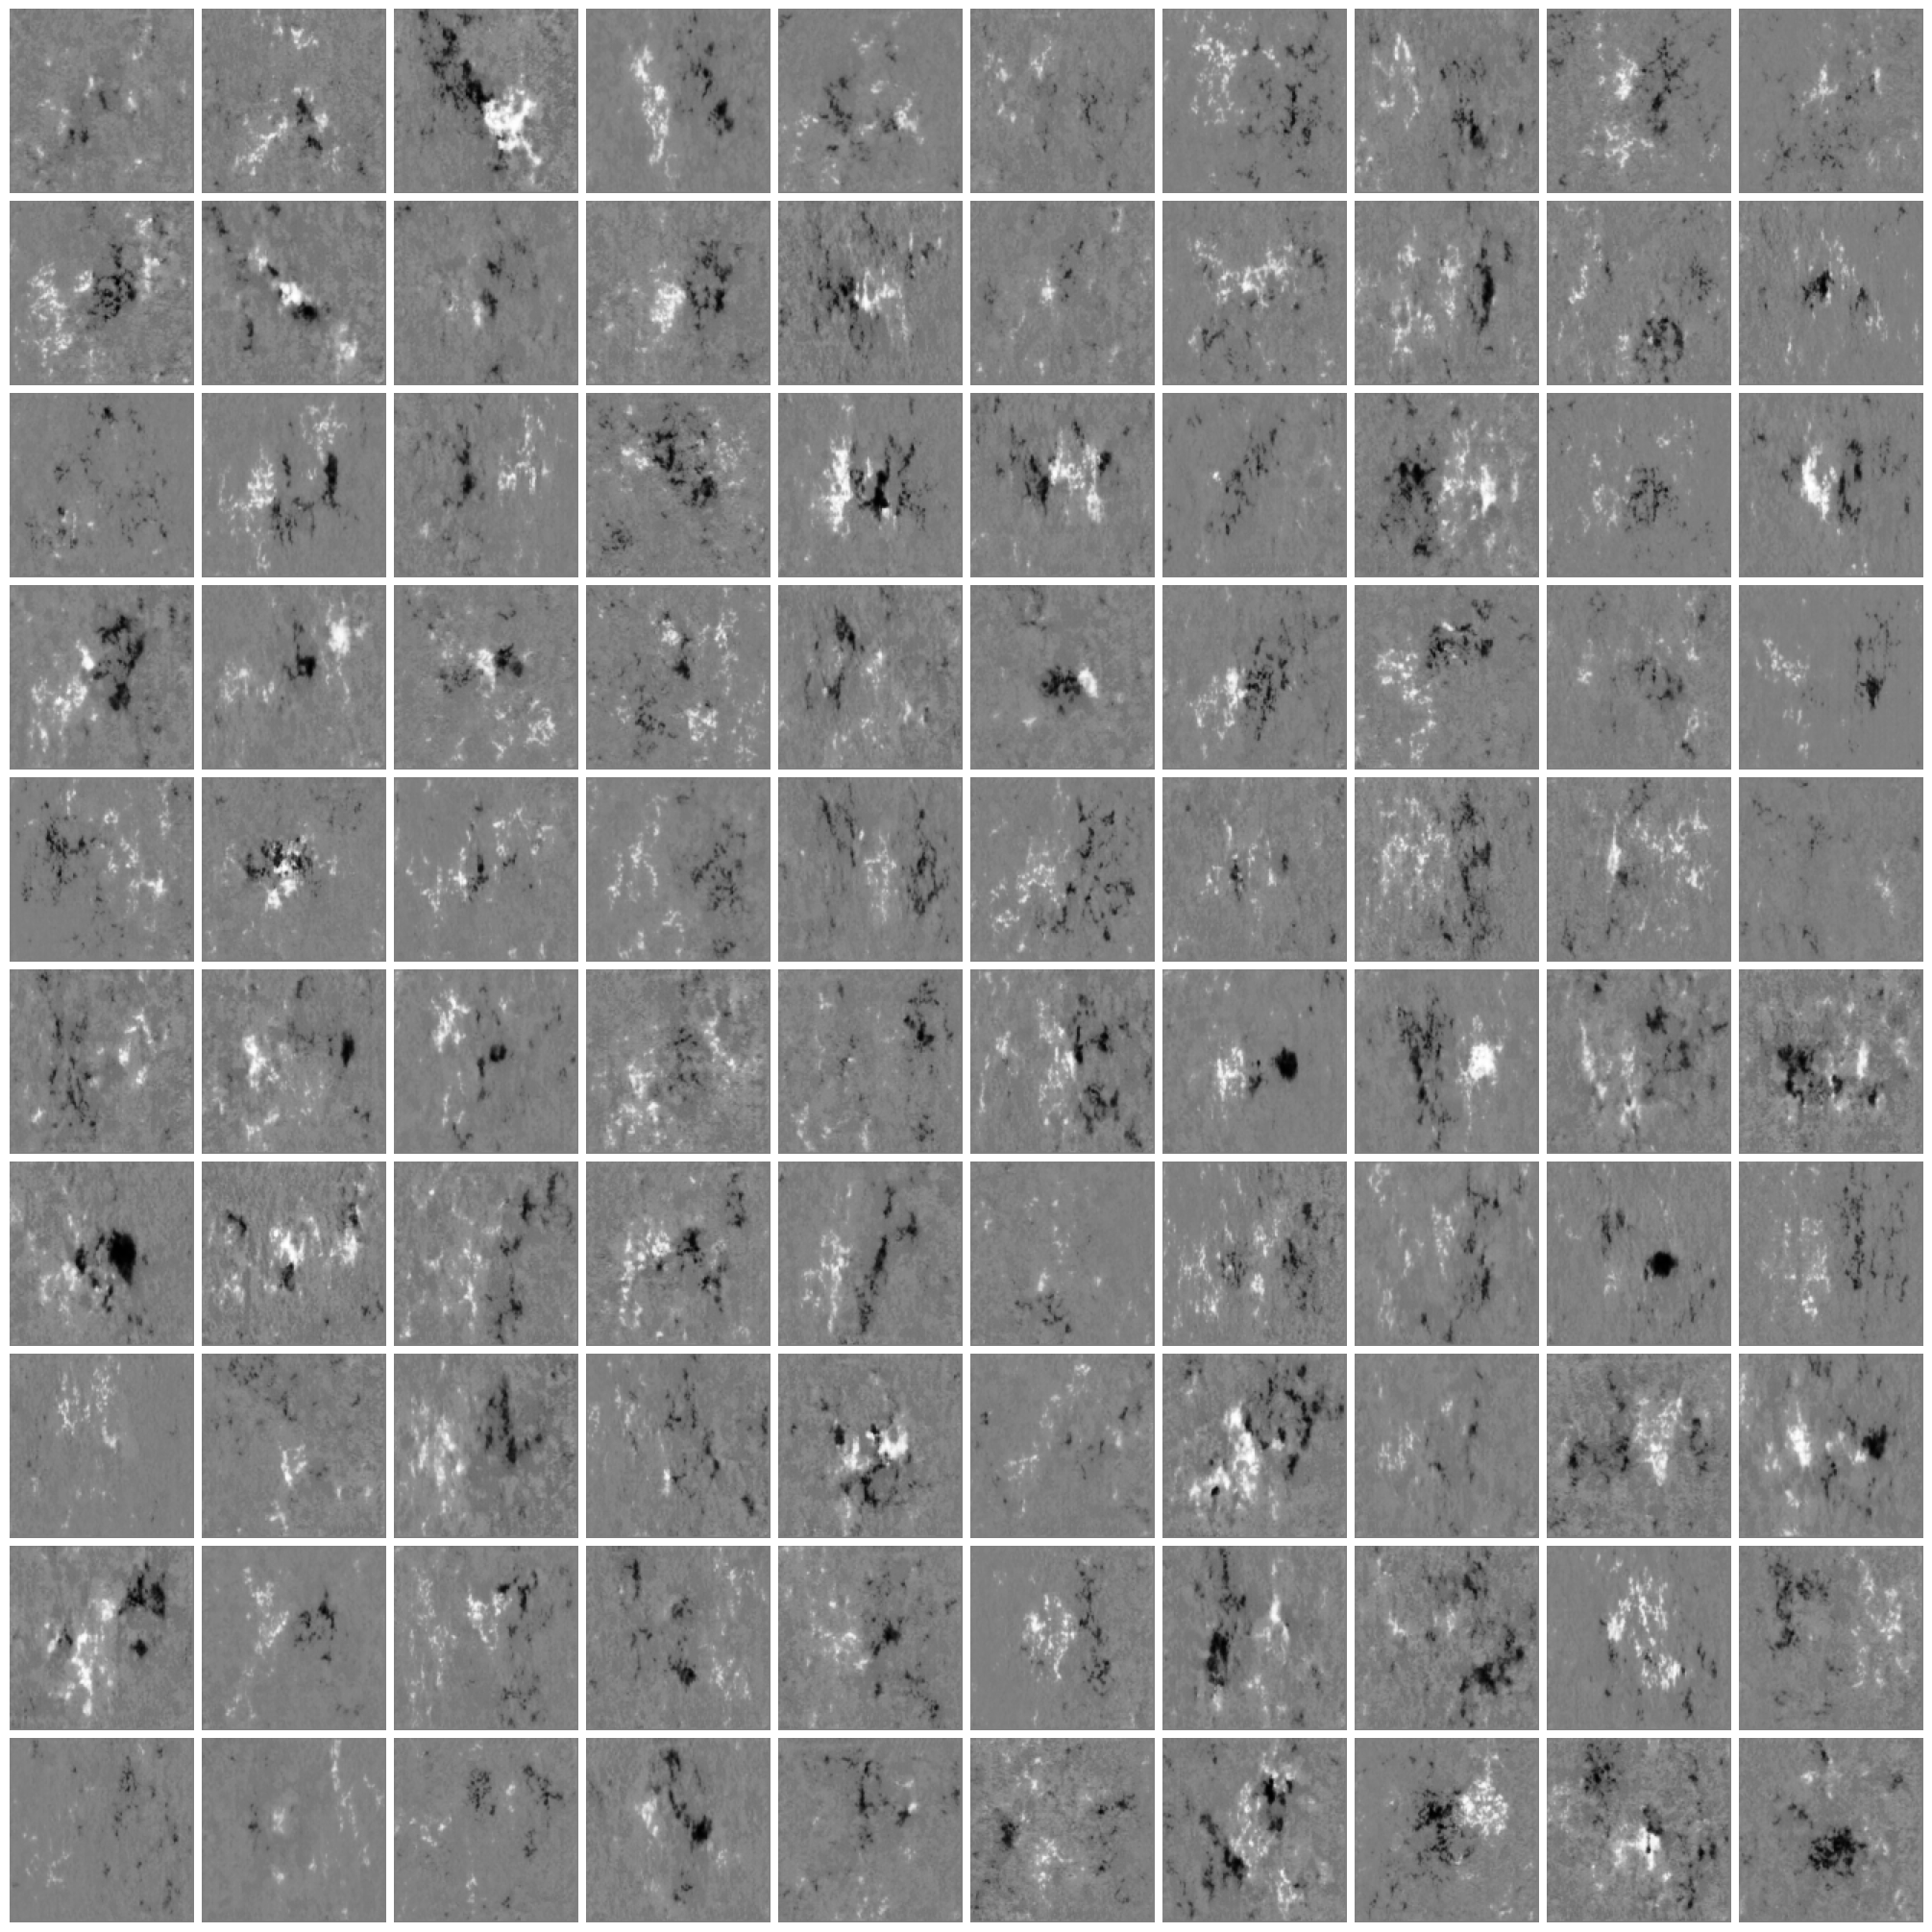

In [23]:
# plot GAN outcome
n_cols = 10
n_rows = 10
z_shift = torch.zeros(n_cols*n_rows, pl_module.hparams.latent_dim).to(pl_module.device)
with torch.no_grad():
    sample_imgs = pl_module(val_z).cpu()

delta = 0.0
fig, axes = plt.subplots(n_cols, n_rows, figsize=(2*n_cols, 2*n_rows), constrained_layout=True)
ax = axes.ravel()

for i in range(n_rows*n_cols):
    im = ax[i].imshow(sample_imgs[i,0,:,:],
                        cmap='gray',
                        vmin= -1 + delta,
                        vmax=1 - delta)
    ax[i].axis('off')

R =  236.90381


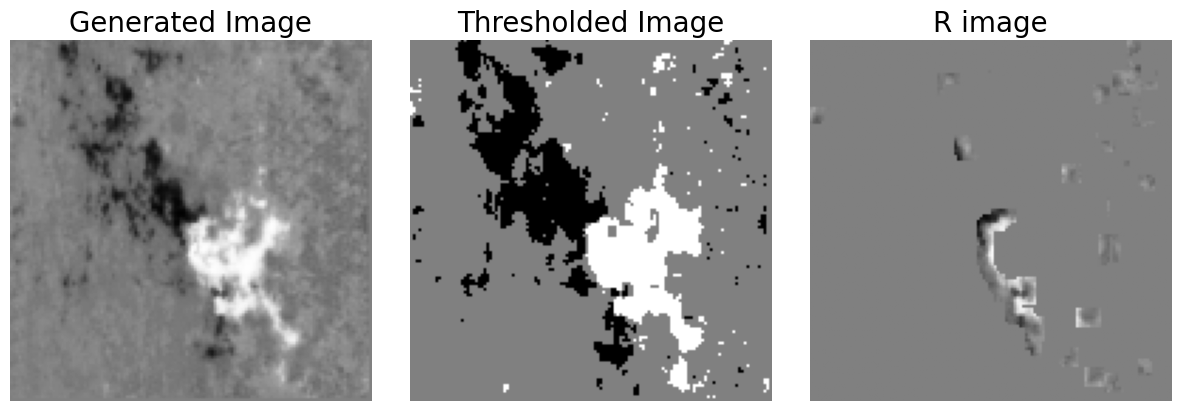

In [24]:
#plot generated thresholded and R-image
fig, axes = plt.subplots(1, 3, figsize=(4*3, 4*1), constrained_layout=True)
idx = 2
th = 0.15
s_test = sample_imgs[idx,0,:,:].numpy()
pos_test = (s_test>th).astype(float)
neg_test = (s_test<-th).astype(float)
ax = axes.ravel()
images = [s_test, pos_test - neg_test, calculate_srij_R(s_test, th)]
titles = ['Generated Image', 'Thresholded Image', 'R image']
for i in range(3):
    ax[i].imshow(images[i], cmap='gray',
                 vmin= -1 + delta, vmax=1 - delta)
    ax[i].axis('off')
    ax[i].set_title(titles[i], fontsize=20)
print('R = ', np.sum(np.abs(calculate_srij_R(s_test, th))))

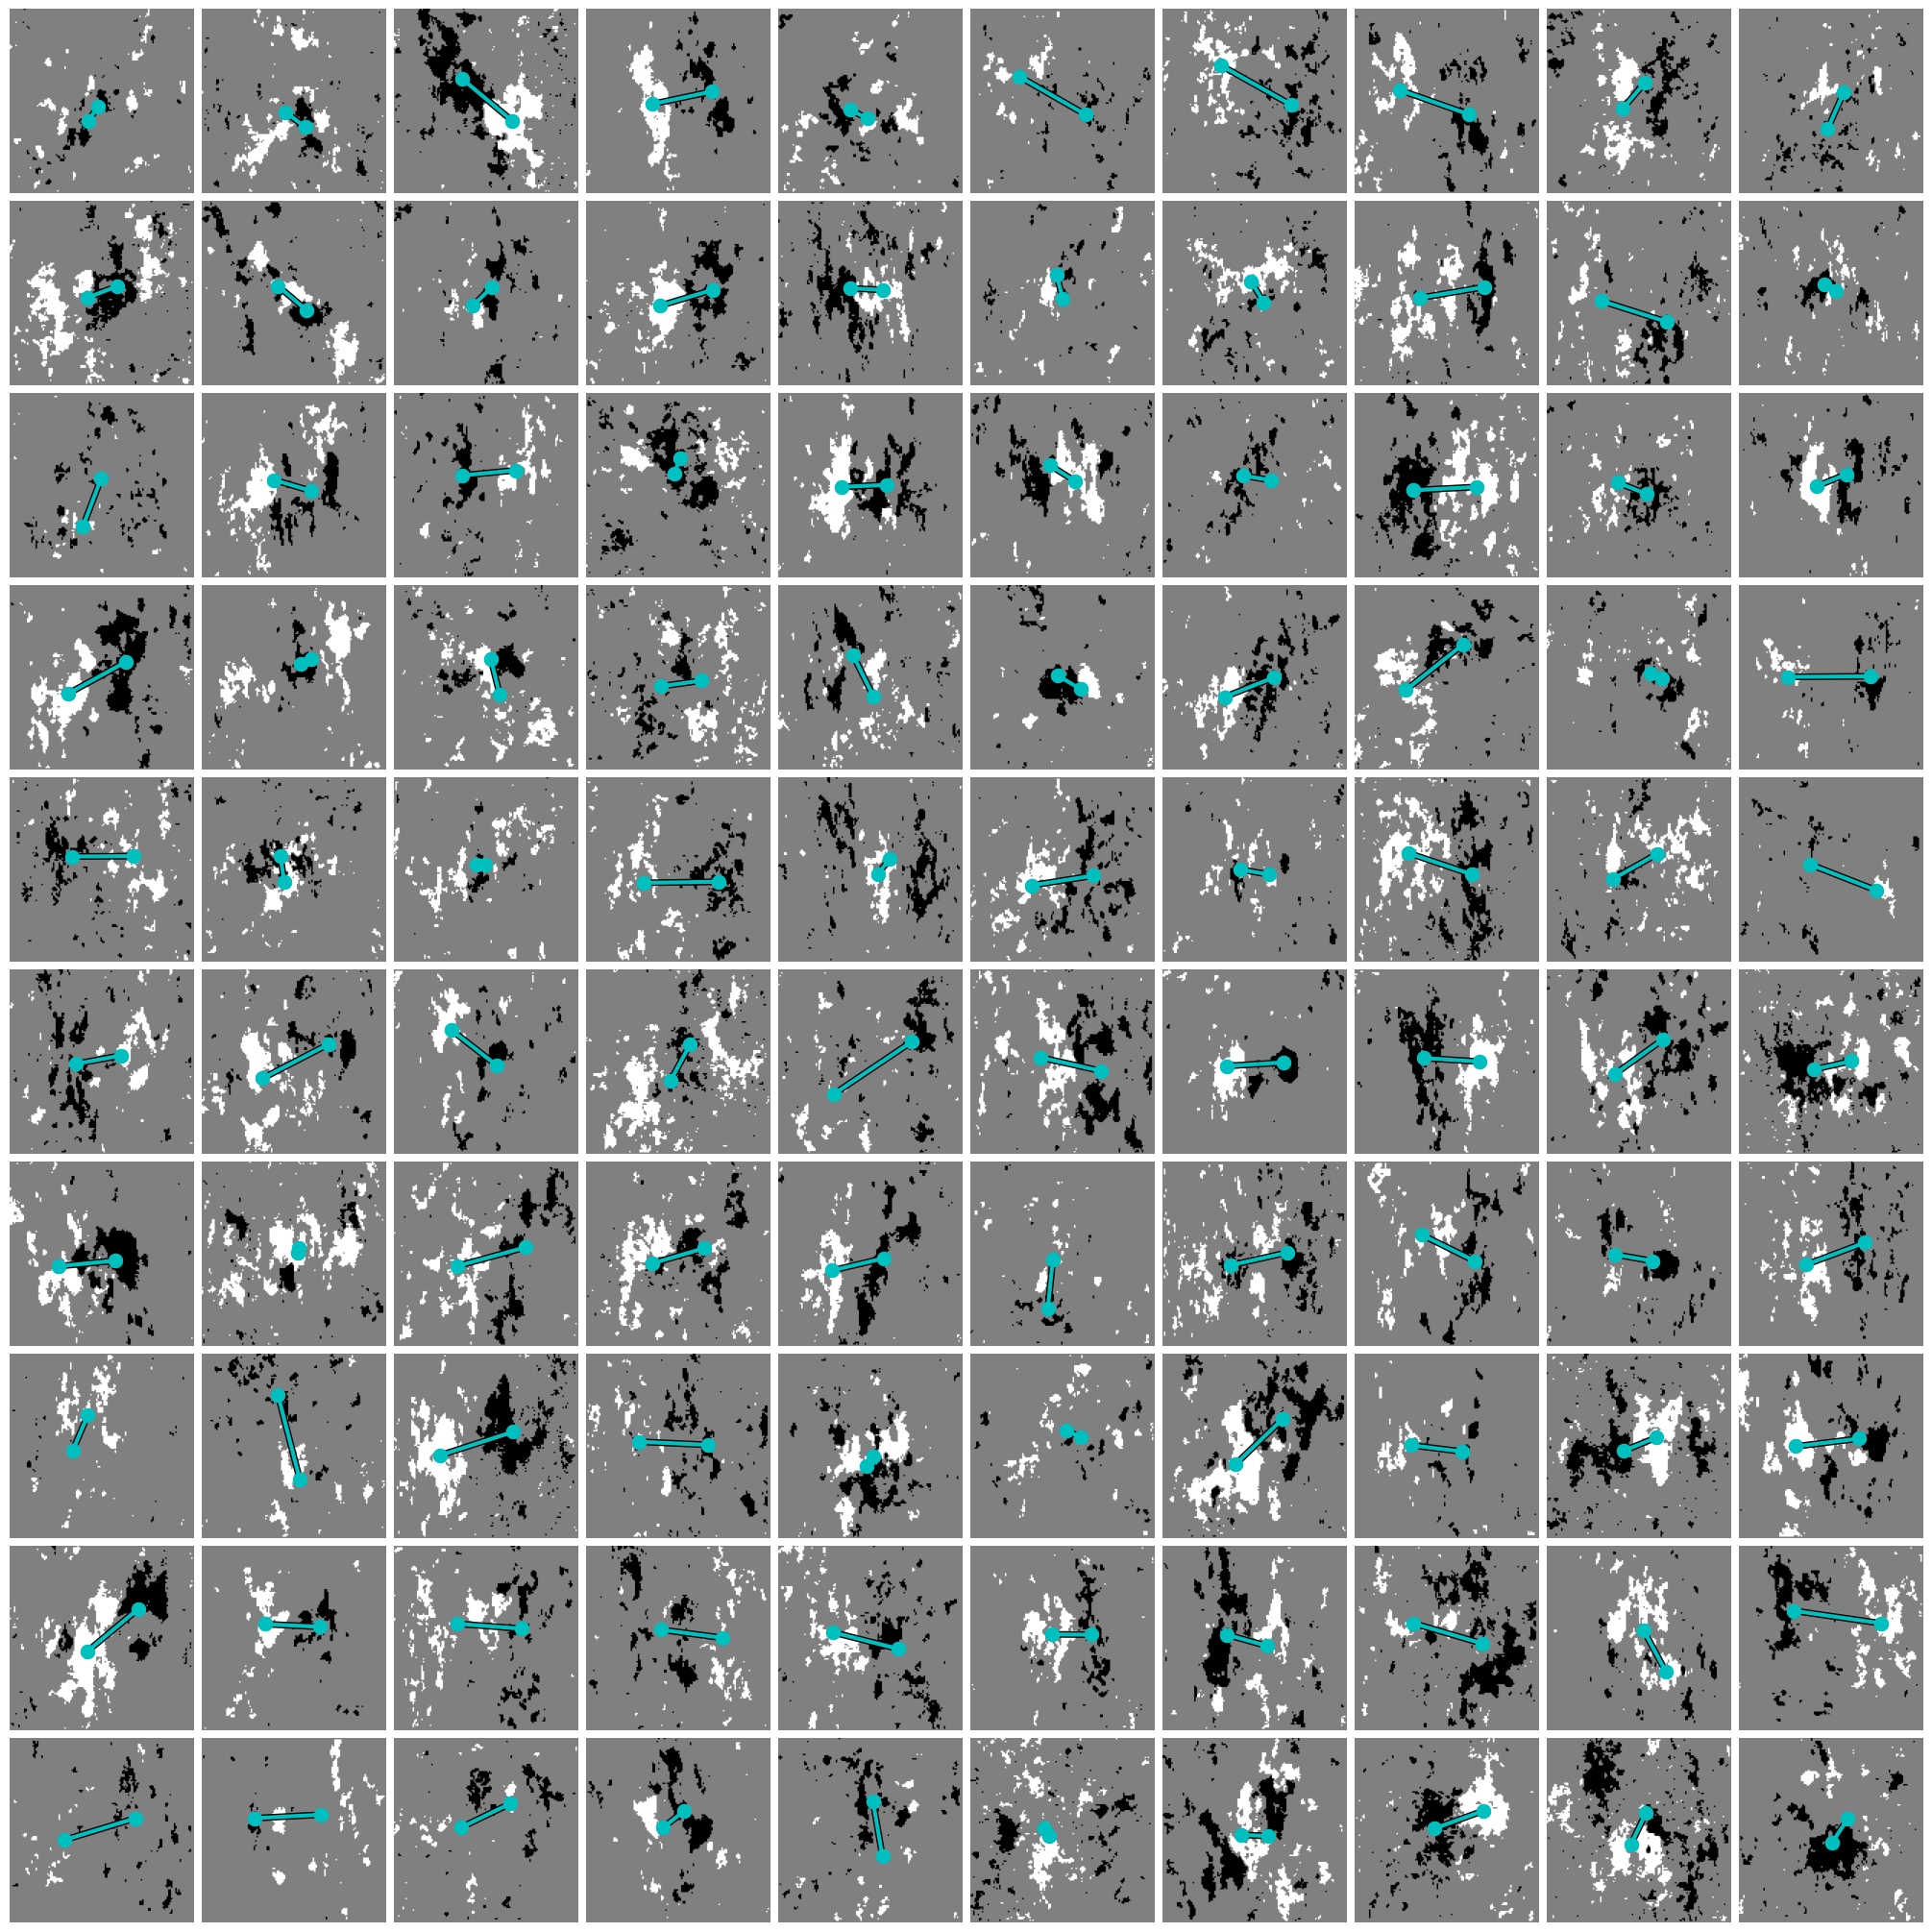

In [25]:
#overlay field-strength weighted centroids on thresholded magnetograms
delta = 0.0
n_cols, n_rows=10, 10
fig, axes = plt.subplots(n_cols, n_rows, figsize=(2*n_cols, 2*n_rows), constrained_layout=True)
ax = axes.ravel()
th = 0.15
d, t, u, p, n, a, l, r = [], [], [], [], [], [], [], []
for i in range(n_rows*n_cols):
    s = sample_imgs[i,0,:,:].numpy()
    pos = (s>th).astype(float)
    neg = (s<-th).astype(float)
    
    if pos.sum()>0 and neg.sum()>0:
        ind_p_y = np.array(np.where(pos==1))[0]
        ind_p_x = np.array(np.where(pos==1))[1]
        ind_n_y = np.array(np.where(neg==1))[0]
        ind_n_x = np.array(np.where(neg==1))[1]
        cen_p_y = np.sum(ind_p_y*s[pos==1])/np.sum(s[pos==1])
        cen_p_x = np.sum(ind_p_x*s[pos==1])/np.sum(s[pos==1])
        cen_n_y = np.sum(ind_n_y*s[neg==1])/np.sum(s[neg==1])
        cen_n_x = np.sum(ind_n_x*s[neg==1])/np.sum(s[neg==1])
        im = ax[i].imshow(pos.astype(float)-neg.astype(float),
                            cmap='gray',
                            vmin= -1 + delta,
                            vmax=1 - delta)
        ax[i].plot([cen_p_x, cen_n_x], [cen_p_y, cen_n_y], '-k', lw=5)
        ax[i].plot([cen_p_x, cen_n_x], [cen_p_y, cen_n_y], '-c', lw=3)
        ax[i].plot([cen_p_x, cen_p_x], [cen_p_y, cen_p_y], '.c', ms=20)
        ax[i].plot([cen_n_x, cen_n_x], [cen_n_y, cen_n_y], '.c', ms=20)
        ax[i].axis('off')
        dis = (cen_n_x - cen_p_x)**2 + (cen_n_y - cen_p_y)**2
        tilt = np.arcsin((cen_n_y - cen_p_y)/(dis**0.5))
        dis = (dis**0.5)/(128*np.sqrt(2))
        uflux = np.abs(s).sum()/(128*128)
        pflux = np.abs(s[pos==1]).sum()/(np.sum(pos))
        nflux = np.abs(s[neg==1]).sum()/(np.sum(neg))
        area = (pos.sum() + neg.sum())/(128*128)
        lp = cen_p_x>cen_n_x
        srij_R = np.sum(np.abs(calculate_srij_R(s, th)))
    else:
        ax[i].imshow(s*0, cmap='gray',
                     vmin= -1 + delta,
                     vmax=1 - delta)
        ax[i].axis('off')

In [26]:
# generate images for 10000 randomly chosen latent vectors
latent_space = torch.randn((10000, pl_module.hparams.latent_dim), device=pl_module.device)
gen_imgs = torch.zeros(10000, 1, 128, 128)
with torch.no_grad():
    gen_imgs = pl_module(latent_space).cpu()

gen_imgs = gen_imgs.numpy()
latent_space = latent_space.cpu().numpy()

In [27]:
#list calculated physical parameters and corresponding latent vectors
distance_target, tilt_target, uflux_target, pflux_target, nflux_target, eflux_target, area_target, lp_target, r_target = [], [], [], [], [], [], [], [], []
for i in range(latent_space.shape[0]):
    dis, tilt, uflux, pflux, nflux, eflux, area, lp, R = calculate_params(gen_imgs[i,0,:,:], 0.15)
    distance_target.append(dis)
    tilt_target.append(tilt)
    uflux_target.append(uflux)
    pflux_target.append(pflux)
    nflux_target.append(nflux)
    eflux_target.append(eflux)
    area_target.append(area)
    lp_target.append(lp)
    r_target.append(R)
    print(i,'--done--')

0 --done--
1 --done--
2 --done--
3 --done--
4 --done--
5 --done--
6 --done--
7 --done--
8 --done--
9 --done--
10 --done--
11 --done--
12 --done--
13 --done--
14 --done--
15 --done--
16 --done--
17 --done--
18 --done--
19 --done--
20 --done--
21 --done--
22 --done--
23 --done--
24 --done--
25 --done--
26 --done--
27 --done--
28 --done--
29 --done--
30 --done--
31 --done--
32 --done--
33 --done--
34 --done--
35 --done--
36 --done--
37 --done--
38 --done--
39 --done--
40 --done--
41 --done--
42 --done--
43 --done--
44 --done--
45 --done--
46 --done--
47 --done--
48 --done--
49 --done--
50 --done--
51 --done--
52 --done--
53 --done--
54 --done--
55 --done--
56 --done--
57 --done--
58 --done--
59 --done--
60 --done--
61 --done--
62 --done--
63 --done--
64 --done--
65 --done--
66 --done--
67 --done--
68 --done--
69 --done--
70 --done--
71 --done--
72 --done--
73 --done--
74 --done--
75 --done--
76 --done--
77 --done--
78 --done--
79 --done--
80 --done--
81 --done--
82 --done--
83 --done--
84

In [28]:
#convert calculated parameters to 0 or 1 based thresholding with median
distance_target = np.array(distance_target)
distance_target = (distance_target > np.median(distance_target)).astype(int)
tilt_target = np.array(tilt_target)
tilt_target = (tilt_target > np.median(tilt_target)).astype(int)
uflux_target = np.array(uflux_target)
uflux_target = (uflux_target > np.median(uflux_target)).astype(int)
pflux_target = np.array(pflux_target)
pflux_target = (pflux_target > np.median(pflux_target)).astype(int)
nflux_target = np.array(nflux_target)
nflux_target = (nflux_target > np.median(nflux_target)).astype(int)
eflux_target = np.array(eflux_target)
eflux_target = (eflux_target > np.median(eflux_target)).astype(int)
area_target = np.array(area_target)
area_target = (area_target > np.median(area_target)).astype(int)
lp_target = np.array(lp_target)
lp_target = (lp_target > np.median(lp_target)).astype(int)
r_target = np.array(r_target)
r_target = (r_target > np.median(r_target)).astype(int)

In [29]:
# Split dataset into training set and test set
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(latent_space, uflux_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(latent_space, pflux_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(latent_space, nflux_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_e, X_test_e, y_train_e, y_test_e = train_test_split(latent_space, eflux_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(latent_space, tilt_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(latent_space, distance_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(latent_space, area_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_l, X_test_l, y_train_l, y_test_l = train_test_split(latent_space, lp_target, test_size=0.3,random_state=23) # 70% training and 30% test
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(latent_space, r_target, test_size=0.3,random_state=23) # 70% training and 30% test

In [30]:
#Train SVM for learning decision boundaries
clf_u = svm.SVC(kernel='linear') # Linear Kernel
clf_u.fit(X_train_u, y_train_u)
y_pred_u = clf_u.predict(X_test_u)

clf_p = svm.SVC(kernel='linear') # Linear Kernel
clf_p.fit(X_train_p, y_train_p)
y_pred_p = clf_p.predict(X_test_p)

clf_n = svm.SVC(kernel='linear') # Linear Kernel
clf_n.fit(X_train_n, y_train_n)
y_pred_n = clf_n.predict(X_test_n)

clf_e = svm.SVC(kernel='linear') # Linear Kernel
clf_e.fit(X_train_e, y_train_e)
y_pred_e = clf_e.predict(X_test_e)

clf_t = svm.SVC(kernel='linear') # Linear Kernel
clf_t.fit(X_train_t, y_train_t)
y_pred_t = clf_t.predict(X_test_t)

clf_d = svm.SVC(kernel='linear') # Linear Kernel
clf_d.fit(X_train_d, y_train_d)
y_pred_d = clf_d.predict(X_test_d)

clf_a = svm.SVC(kernel='linear') # Linear Kernel
clf_a.fit(X_train_a, y_train_a)
y_pred_a = clf_a.predict(X_test_a)

clf_l = svm.SVC(kernel='linear') # Linear Kernel
clf_l.fit(X_train_l, y_train_l)
y_pred_l = clf_l.predict(X_test_l)

clf_r = svm.SVC(kernel='linear') # Linear Kernel
clf_r.fit(X_train_r, y_train_r)
y_pred_r = clf_r.predict(X_test_r)

In [31]:
#Calculate test accuracy of SVM classifiers
print("usflux Accuracy:",metrics.accuracy_score(y_test_u, y_pred_u))
print("pflux Accuracy:",metrics.accuracy_score(y_test_p, y_pred_p))
print("nflux Accuracy:",metrics.accuracy_score(y_test_n, y_pred_n))
print("eflux Accuracy:",metrics.accuracy_score(y_test_e, y_pred_e))
print("tilt Accuracy:",metrics.accuracy_score(y_test_t, y_pred_t))
print("distance Accuracy:",metrics.accuracy_score(y_test_d, y_pred_d))
print("area Accuracy:",metrics.accuracy_score(y_test_a, y_pred_a))
print("lp Accuracy:",metrics.accuracy_score(y_test_l, y_pred_l))
print("r Accuracy:",metrics.accuracy_score(y_test_r, y_pred_r))


usflux Accuracy: 0.8416666666666667
pflux Accuracy: 0.7153333333333334
nflux Accuracy: 0.7156666666666667
eflux Accuracy: 0.735
tilt Accuracy: 0.7846666666666666
distance Accuracy: 0.638
area Accuracy: 0.8133333333333334
lp Accuracy: 0.9213333333333333
r Accuracy: 0.781


In [32]:
#Calculate test Precision and Recall of SVM classifiers
print("usflux Precision:",metrics.precision_score(y_test_u, y_pred_u))
print("usflux Recall:",metrics.recall_score(y_test_u, y_pred_u))
print("pflux Precision:",metrics.precision_score(y_test_p, y_pred_p))
print("pflux Recall:",metrics.recall_score(y_test_p, y_pred_p))
print("nflux Precision:",metrics.precision_score(y_test_n, y_pred_n))
print("nflux Recall:",metrics.recall_score(y_test_n, y_pred_n))
print("eflux Precision:",metrics.precision_score(y_test_e, y_pred_e))
print("eflux Recall:",metrics.recall_score(y_test_e, y_pred_e))
print("tilt Precision:",metrics.precision_score(y_test_t, y_pred_t))
print("tilt Recall:",metrics.recall_score(y_test_t, y_pred_t))
print("dist Precision:",metrics.precision_score(y_test_d, y_pred_d))
print("dist Recall:",metrics.recall_score(y_test_d, y_pred_d))
print("area Precision:",metrics.precision_score(y_test_a, y_pred_a))
print("area Recall:",metrics.recall_score(y_test_a, y_pred_a))
print("lp Precision:",metrics.precision_score(y_test_l, y_pred_l))
print("lp Recall:",metrics.recall_score(y_test_l, y_pred_l))
print("r Precision:",metrics.precision_score(y_test_r, y_pred_r))
print("r Recall:",metrics.recall_score(y_test_r, y_pred_r))

usflux Precision: 0.8433734939759037
usflux Recall: 0.8394403730846103
pflux Precision: 0.714859437751004
pflux Recall: 0.713903743315508
nflux Precision: 0.7175521183591123
nflux Recall: 0.7113333333333334
eflux Precision: 0.7324883255503669
eflux Recall: 0.7359249329758714
tilt Precision: 0.7854694996572995
tilt Recall: 0.7748478701825557
dist Precision: 0.6602516654330126
dist Recall: 0.587228439763002
area Precision: 0.824847250509165
area Recall: 0.8009228740936059
lp Precision: 0.8992506244796004
lp Recall: 0.9037656903765691
r Precision: 0.7782258064516129
r Recall: 0.7797979797979798


In [33]:
#Calculate normals to SVM derived decision boundaries
uflux_normal = clf_u.coef_[0]/(np.sum(clf_u.coef_[0]**2)**0.5)
pflux_normal = clf_p.coef_[0]/(np.sum(clf_p.coef_[0]**2)**0.5)
nflux_normal = clf_n.coef_[0]/(np.sum(clf_n.coef_[0]**2)**0.5)
eflux_normal = clf_e.coef_[0]/(np.sum(clf_e.coef_[0]**2)**0.5)
tilt_normal = clf_t.coef_[0]/(np.sum(clf_t.coef_[0]**2)**0.5)
dist_normal = clf_d.coef_[0]/(np.sum(clf_d.coef_[0]**2)**0.5)
area_normal = clf_a.coef_[0]/(np.sum(clf_a.coef_[0]**2)**0.5)
lp_normal = clf_l.coef_[0]/(np.sum(clf_l.coef_[0]**2)**0.5)
r_normal = clf_r.coef_[0]/(np.sum(clf_r.coef_[0]**2)**0.5)

6.4 19
6.4 19


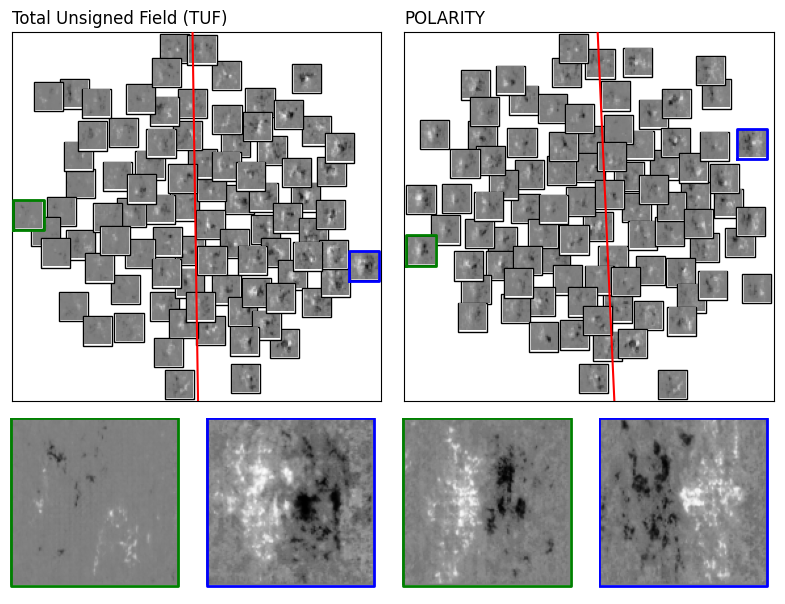

In [34]:
clfs = [clf_u, clf_l]
titles = ['Total Unsigned Field (TUF)', 'POLARITY']
type='custom'
ts = 0.09
fig = plt.figure(figsize=(8, 10))

# Define dimensions
big_size = 4  # Multiplier for the size of top-row axes
small_size = 1  # Multiplier for the size of bottom-row axes
base_size = 1  # Base size for each small square

# Top row axes
ax1 = plt.subplot2grid((5, 4), (0, 0), rowspan=2, colspan=2)
ax2 = plt.subplot2grid((5, 4), (0, 2), rowspan=2, colspan=2)

# Bottom row axes
ax3 = plt.subplot2grid((5, 4), (2, 0))
ax4 = plt.subplot2grid((5, 4), (2, 1))
ax5 = plt.subplot2grid((5, 4), (2, 2))
ax6 = plt.subplot2grid((5, 4), (2, 3))

# Set aspect ratio for all axes
ax = [ax1, ax2]
    
imgs = []
for i in range(2):
    latent_plane = hyperplane(latent_space, clfs[i])
    embeddings_2d = project_latent_2d(latent_space, latent_plane, clfs[i],type=type)
    _, cmin, cmax, img_min, img_max = image_on_latent(gen_imgs, embeddings_2d[:10000,:], embeddings_2d[10000:,:],
                                     type=type, title = titles[i], mask = False, pol_connect=False, ax=ax[i], fig=fig)
    e1 = np.array(cmin) - ts/2
    e2 = np.array(cmax) - ts/2
    ax[i].plot([e1[0], e1[0], e1[0]+ts, e1[0]+ts, e1[0]],[e1[1],e1[1]+ts, e1[1]+ts, e1[1], e1[1]], '-g', lw=2 ,zorder=101)
    ax[i].plot([e2[0], e2[0], e2[0]+ts, e2[0]+ts, e2[0]],[e2[1],e2[1]+ts, e2[1]+ts, e2[1], e2[1]], '-b', lw=2 ,zorder=101)
    imgs.append(img_min)
    imgs.append(img_max)
   
i_s = 128
for i, ax in enumerate([ax3, ax4, ax5, ax6]):
    ax.set_aspect(base_size / base_size)
    ax.imshow(imgs[i],vmin=-1,vmax=1, cmap='gray')
    
    if i%2==0:
        ax.plot([0, 0, i_s, i_s, 0],[0, i_s, i_s, 0, 0], '-g', lw=2)# ,zorder=101)
    else:
        ax.plot([0, 0, i_s, i_s, 0],[0, i_s, i_s, 0, 0], '-b', lw=2)# ,zorder=101)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

d:-0.2932274546145015, t:-0.03775728751838987, a:0.9720424209095484, lp:-0.08179212168189991, r: 0.898102744602565


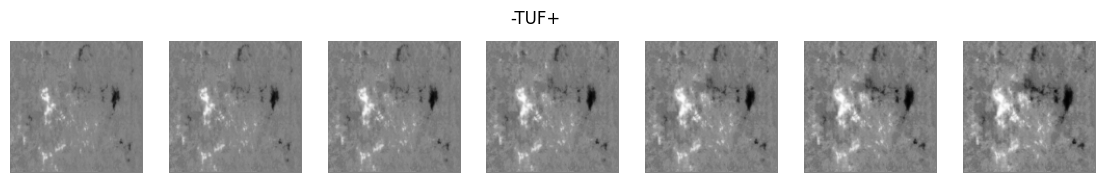

In [16]:
#Modify Generated Data along the Direction of Total Unsigned Field (TUF)
idx = 51
dist_proj = np.dot(uflux_normal, dist_normal)
area_proj = np.dot(uflux_normal, area_normal)
tilt_proj = np.dot(uflux_normal, tilt_normal)
lp_proj = np.dot(uflux_normal, lp_normal)
r_proj = np.dot(uflux_normal, r_normal)
print(f'd:{dist_proj}, t:{tilt_proj}, a:{area_proj}, lp:{lp_proj}, r: {r_proj}')
plt.figure(figsize=(14,2))
plt.suptitle('-TUF+')
ss, uu = [], []
for i in range(7):
    eps = 0.5*(i-3)
    ss.append(eps)
    u = torch.from_numpy(uflux_normal).to(device)
    u = u.type_as(val_z)
    z_shift = val_z[idx, :] + eps*(u)
    with torch.no_grad():
        shifted_img = pl_module(z_shift[None,:].to(device)).cpu()
    plt.subplot(1,7,i+1)
    plt.imshow(shifted_img.detach()[0,0,:,:],
                        cmap='gray',
                        vmin= -1 + delta,
                        vmax=1 - delta)

    uu.append(np.sum(np.abs(shifted_img.detach()[0,0,:,:].numpy())))
    plt.axis('off')

d:-0.2932274546145015, t:-0.03775728751838987, a:0.9720424209095484, lp:-0.08179212168189991, r: 0.898102744602565


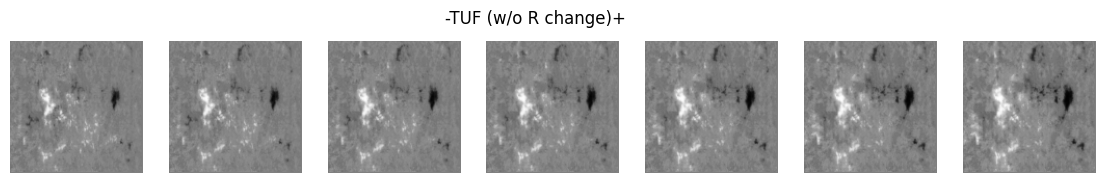

In [65]:
#Modify Generated Data along the Direction of TUR w/o Change in R
idx = 51
dist_proj = np.dot(uflux_normal, dist_normal)
area_proj = np.dot(uflux_normal, area_normal)
tilt_proj = np.dot(uflux_normal, tilt_normal)
lp_proj = np.dot(uflux_normal, lp_normal)
r_proj = np.dot(uflux_normal, r_normal)
print(f'd:{dist_proj}, t:{tilt_proj}, a:{area_proj}, lp:{lp_proj}, r: {r_proj}')
plt.figure(figsize=(14,2))
plt.suptitle('-TUF (w/o R change)+')
ss, uu = [], []
for i in range(7):
    eps = 0.5*(i-3)
    ss.append(eps)
    new_normal = uflux_normal - r_proj*r_normal
    new_normal = new_normal/(np.sum(new_normal**2)**0.5)
    u = torch.from_numpy(new_normal).to(device)
    u = u.type_as(val_z)
    z_shift = val_z[idx, :] + eps*(u)
    with torch.no_grad():
        shifted_img = pl_module(z_shift[None,:].to(device)).cpu()
    plt.subplot(1,7,i+1)
    plt.imshow(shifted_img.detach()[0,0,:,:],
                        cmap='gray',
                        vmin= -1 + delta,
                        vmax=1 - delta)

    uu.append(np.sum(np.abs(shifted_img.detach()[0,0,:,:].numpy())))
    plt.axis('off')

u:-0.2932274546145015, t:-0.11306397404234315, a:-0.31932640910701937, lp:-0.5960473670757518, r: -0.5692819368506159


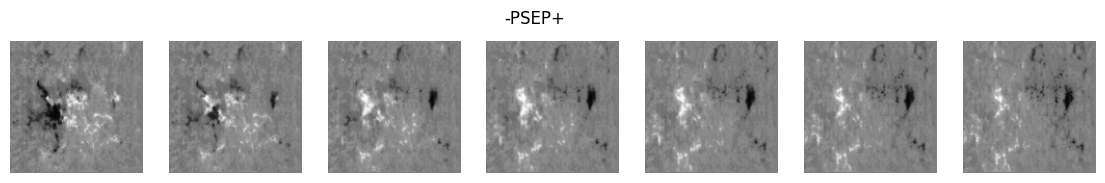

In [66]:
#Modify Generated Data along the Direction of Polarity Separation (PSEP)
idx = 51
uflux_proj = np.dot(dist_normal, uflux_normal)
area_proj = np.dot(dist_normal, area_normal)
tilt_proj = np.dot(dist_normal, tilt_normal)
lp_proj = np.dot(dist_normal, lp_normal)
r_proj = np.dot(dist_normal, r_normal)
print(f'u:{uflux_proj}, t:{tilt_proj}, a:{area_proj}, lp:{lp_proj}, r: {r_proj}')
plt.figure(figsize=(14,2))
plt.suptitle('-PSEP+')
for i in range(7):
    eps = (i-3)
    u = torch.from_numpy(dist_normal).to(device)
    u = u.type_as(val_z)
    z_shift = val_z[idx, :] + eps*(u)
    with torch.no_grad():
        shifted_img = pl_module(z_shift[None,:].to(device)).cpu()
        
    s_img = shifted_img.detach()[0,0,:,:].numpy()
    plt.subplot(1,7,i+1)
    plt.imshow(s_img, cmap='gray', vmin= -1 + delta, vmax=1 - delta)
    plt.axis('off')

u:-0.2932274546145015, t:-0.11306397404234315, a:-0.31932640910701937, lp:-0.5960473670757518, r: -0.5692819368506159


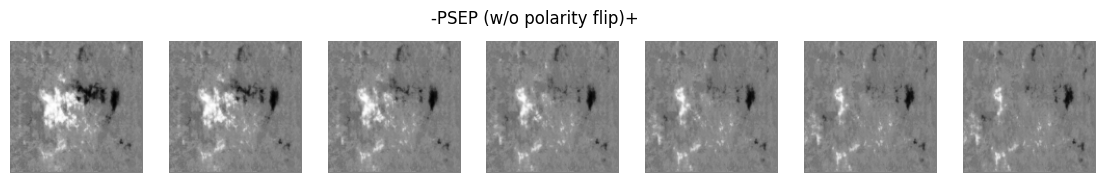

In [36]:
#Modify Generated Data along the Direction of PSEP w/o Polarity Flip
idx = 51
uflux_proj = np.dot(dist_normal, uflux_normal)
area_proj = np.dot(dist_normal, area_normal)
tilt_proj = np.dot(dist_normal, tilt_normal)
lp_proj = np.dot(dist_normal, lp_normal)
r_proj = np.dot(dist_normal, r_normal)
print(f'u:{uflux_proj}, t:{tilt_proj}, a:{area_proj}, lp:{lp_proj}, r: {r_proj}')
plt.figure(figsize=(14,2))
plt.suptitle('-PSEP (w/o polarity flip)+')
for i in range(7):
    eps = (i-3)
    new_normal = dist_normal - lp_proj*lp_normal 
    new_normal = new_normal/(np.sum(new_normal**2)**0.5)
    u = torch.from_numpy(new_normal).to(device)
    u = u.type_as(val_z)
    z_shift = val_z[idx, :] + eps*(u)
    with torch.no_grad():
        shifted_img = pl_module(z_shift[None,:].to(device)).cpu()
        
    s_img = shifted_img.detach()[0,0,:,:].numpy()
    plt.subplot(1,7,i+1)
    plt.imshow(s_img, cmap='gray', vmin= -1 + delta, vmax=1 - delta)
    plt.axis('off')

u:-0.2932274546145015, t:-0.11306397404234315, a:-0.31932640910701937, lp:-0.5960473670757518, r: -0.5692819368506159


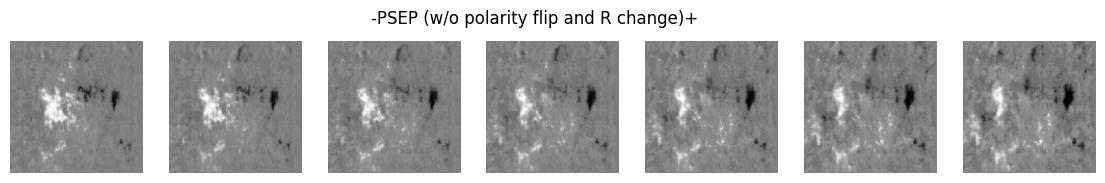

In [18]:
#Modify Generated Data along the Direction of PSEP w/o Polarity Flip and R change
idx = 51
uflux_proj = np.dot(dist_normal, uflux_normal)
area_proj = np.dot(dist_normal, area_normal)
tilt_proj = np.dot(dist_normal, tilt_normal)
lp_proj = np.dot(dist_normal, lp_normal)
r_proj = np.dot(dist_normal, r_normal)
print(f'u:{uflux_proj}, t:{tilt_proj}, a:{area_proj}, lp:{lp_proj}, r: {r_proj}')
plt.figure(figsize=(14,2))
plt.suptitle('-PSEP (w/o polarity flip and R change)+')
for i in range(7):
    eps = (i-3)
    new_normal = project_boundary(dist_normal[None,:], lp_normal[None,:], r_normal[None,:]) 
    new_normal = new_normal/(np.sum(new_normal**2)**0.5)
    u = torch.from_numpy(new_normal).to(device)
    u = u.type_as(val_z)
    z_shift = val_z[idx, :] + eps*(u)
    with torch.no_grad():
        shifted_img = pl_module(z_shift[None,:].to(device)).cpu()
        
    s_img = shifted_img.detach()[0,0,:,:].numpy()
    plt.subplot(1,7,i+1)
    plt.imshow(s_img, cmap='gray', vmin= -1 + delta, vmax=1 - delta)
    plt.axis('off')

## Querying Generated Data to Retrieve Real Matches
* Uses a Self-Supervised Learning model SimSiam

In [19]:
ep = '81'
name = f'GAN_sharp_experiment_ld_100_bs_32_lr_0.0005_stride_1_crop_False_arch_simple_epoch={ep}.ckpt'
MODEL_DIR = './models/'
generator = GAN.load_from_checkpoint(MODEL_DIR + name)
device = 'cuda:0'
generator.to(device)    
# generate query image with GAN  
torch.manual_seed(23)
val_z = torch.randn((1000, generator.hparams.latent_dim), device=generator.device)

with torch.no_grad():
    sample_imgs = -generator(val_z).cpu() # remove '-' to go back to original polarity of generated patches
    
real_imgs = []
dist = 'EUCLIDEAN'
proj = False
odim = 100
#SimSiam model
model_name = 'Subh_SIMSIAM_ftrs_512_pretrained_False_projdim_512_preddim_128_odim_100_contrastive_False_SHARP_stride_1_batch_64_optim_sgd_lr_0.0125_schedule_coeff_1.0_constrained_epoch=09.ckpt'
pl_module = load_model(MODEL_DIR + model_name).to(device)
pl_module.eval()
    
for gen_idx in range(1000):
    query_image = 0.5*(1 + sample_imgs[gen_idx, 0, :, :])


    # search nearest neighbors from SSL embedding dictionary
    tensor = query_image[None, None, :, :]

    with torch.no_grad():
        embedding = pl_module.backbone(tensor.to(device))
        embedding = embedding.flatten(start_dim=1)
        if proj:
            embedding = pl_module.projection_head(embedding)
        
        
    query_embedding = embedding[0].cpu().data.numpy()    
    n_images = 1
    p = pickle.load(open("./data/embeddings_dict_SHARP_mag_proj_False_odim_100_constrained.p",'rb'))

    nn_filenames = fetch_n_neighbor_filenames(query_embedding,
                                        p,
                                        dist,
                                        num_images=n_images)

    print(nn_filenames)
    file = h5py.File(nn_filenames[0])
    key = list(file.keys())[0]
    data = np.array(file[key])
    data = np.clip(data, -1000, 1000)/1000
    data = np.nan_to_num(data, copy=False, nan=0.0, posinf=1, neginf=-1)
    img = cv2.resize(data[0, :, :], (128, 128),interpolation = cv2.INTER_AREA)
    real_imgs.append(img)
    print(gen_idx)


['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.6986.20170421_234800_TAI.h5']
0
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.9348.20230410_074800_TAI.h5']
1
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.9348.20230408_234800_TAI.h5']
2
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.1165.20111207_234800_TAI.h5']
3
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.2716.20130514_154800_TAI.h5']
4
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.355.20110204_154800_TAI.h5']
5
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.8545.20220826_234800_TAI.h5']
6
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.355.20110207_154800_TAI.h5']
7
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.4616.20141007_074800_TAI.h5']
8
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.7638.20210702_074800_TAI.h5']
9
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.1946.20120820_154800_TAI.h5']
10
['/d0/kvandersande/sharps_hdf5/hmi.sharp_cea_720s.7237.20180206_234800_TAI.h5']
11
['/d0/kvandersan

In [20]:
def calculate_params_(s, th):
    pos = (s>th).astype(float)
    neg = (s<-th).astype(float)
    if pos.sum()>0 and neg.sum()>0:
        ind_p_y = np.array(np.where(pos==1))[0]
        ind_p_x = np.array(np.where(pos==1))[1]
        ind_n_y = np.array(np.where(neg==1))[0]
        ind_n_x = np.array(np.where(neg==1))[1]
        cen_p_y = np.sum(ind_p_y*s[pos==1])/np.sum(s[pos==1])
        cen_p_x = np.sum(ind_p_x*s[pos==1])/np.sum(s[pos==1])
        cen_n_y = np.sum(ind_n_y*s[neg==1])/np.sum(s[neg==1])
        cen_n_x = np.sum(ind_n_x*s[neg==1])/np.sum(s[neg==1])
        dis = (cen_n_x - cen_p_x)**2 + (cen_n_y - cen_p_y)**2
        tilt = np.arcsin((cen_n_y - cen_p_y)/(dis**0.5))
        dis = (dis**0.5)/(128*np.sqrt(2))
        uflux = np.abs(s).sum()/(128*128)
        pflux = np.abs(s[s>0]).sum()/np.sum(s>0)
        nflux = np.abs(s[s<0]).sum()/np.sum(s<0)
        eflux = s[pos==1].sum() + s[neg==1].sum()
        area = (pos.sum() + neg.sum())/(128*128)
        lp = cen_p_x - cen_n_x
        R = np.sum(np.abs(calculate_srij_R(s, 0.15)))
        return dis, tilt, uflux, pflux, nflux, eflux, area, lp, R
    else:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan

In [21]:
# Calculate physical parameters from Generated Images and Real matches
#You need to have SHARP data downloaded to run this cell and the next
gen_uflux, real_uflux = [], []
gen_R, real_R = [], []
gen_d, real_d = [], []
gen_p, real_p = [], []
gen_n, real_n = [], []
gen_t, real_t = [], []
gen_a, real_a = [], []
gen_l, real_l = [], []
gen_e, real_e = [], []
for i in range(1000):
    print(i+1)
    gen = sample_imgs[i, 0, :, :].numpy()
    real = real_imgs[i]
    d_r,t_r,u_r,p_r,n_r,e_r,a_r, lp_r, r_r = calculate_params_(real, 0.15)
    d_g,t_g,u_g,p_g,n_g,e_g,a_g, lp_g, r_g = calculate_params_(gen, 0.15)
    gen_uflux.append(u_g*128*128)
    real_uflux.append(u_r*128*128)
    gen_d.append(d_g)
    real_d.append(d_r)
    gen_R.append(r_g)
    real_R.append(r_r)
    gen_p.append(p_g)
    real_p.append(p_r)
    gen_n.append(n_g)
    real_n.append(n_r)
    gen_t.append(t_g)
    real_t.append(t_r)
    gen_l.append(lp_g)
    real_l.append(lp_r)
    gen_e.append(e_g)
    real_e.append(e_r)
    gen_a.append(a_g)
    real_a.append(a_r)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585


Text(0.5, 1.0, 'Retrieved Real Image')

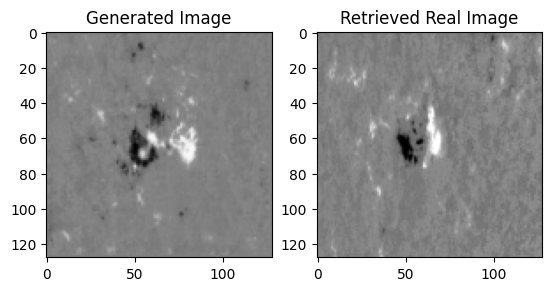

In [22]:
#Plot a generated image and corresponding real match
i=900
plt.subplot(1,2,1)
plt.imshow(sample_imgs[i, 0, :, :].numpy(), vmin=-1, vmax=1, cmap='gray')
plt.title('Generated Image')
plt.subplot(1,2,2)
plt.imshow(real_imgs[i], vmin=-1, vmax=1,cmap='gray')
plt.title('Retrieved Real Image')

In [30]:
## Pearson correlations between Generated image and Real match parameters
gen_d, real_d = np.array(gen_d), np.array(real_d)
mask = ~np.isnan(gen_d) & ~np.isnan(real_d)
print('--d--',np.corrcoef(gen_d[mask], real_d[mask])[0,1])
gen_R, real_R = np.array(gen_R), np.array(real_R)
mask = ~np.isnan(gen_R) & ~np.isnan(real_R)
print('--R--', np.corrcoef(gen_R[mask], real_R[mask])[0,1])
gen_uflux, real_uflux = np.array(gen_uflux), np.array(real_uflux)
mask = ~np.isnan(gen_uflux) & ~np.isnan(real_uflux)
print('--TUF--', np.corrcoef(gen_uflux[mask], real_uflux[mask])[0,1])
gen_p, real_p = np.array(gen_p), np.array(real_p)
mask = ~np.isnan(gen_p) & ~np.isnan(real_p)
print('--TPF--', np.corrcoef(gen_p[mask], real_p[mask])[0,1])
gen_n, real_n = np.array(gen_n), np.array(real_n)
mask = ~np.isnan(gen_n) & ~np.isnan(real_n)
print('--TNF--', np.corrcoef(gen_n[mask], real_n[mask])[0,1])

--d-- 0.2816466221003068
--R-- 0.7269035049448334
--TUF-- 0.779267850505639
--TPF-- 0.6915713353545139
--TNF-- 0.7159982404223254


In [31]:
## Spearman rank correlations between Generated image and Real match parameters
gen_d, real_d = np.array(gen_d), np.array(real_d)
mask = ~np.isnan(gen_d) & ~np.isnan(real_d)
res = stats.spearmanr(gen_d[mask], real_d[mask])
print('--d--',res.statistic)

gen_R, real_R = np.array(gen_R), np.array(real_R)
mask = ~np.isnan(gen_R) & ~np.isnan(real_R)
res = stats.spearmanr(gen_R[mask], real_R[mask])
print('--R--',res.statistic)

gen_uflux, real_uflux = np.array(gen_uflux), np.array(real_uflux)
mask = ~np.isnan(gen_uflux) & ~np.isnan(real_uflux)
res = stats.spearmanr(gen_uflux[mask], real_uflux[mask])
print('--TUF--',res.statistic)

gen_p, real_p = np.array(gen_p), np.array(real_p)
mask = ~np.isnan(gen_p) & ~np.isnan(real_p)
res = stats.spearmanr(gen_p[mask], real_p[mask])
print('--TPF--',res.statistic)

gen_n, real_n = np.array(gen_n), np.array(real_n)
mask = ~np.isnan(gen_n) & ~np.isnan(real_n)
res = stats.spearmanr(gen_n[mask], real_n[mask])
print('--TNF--',res.statistic)

--d-- 0.3122572319754551
--R-- 0.7604259783059841
--TUF-- 0.7874043469105544
--TPF-- 0.6999351890463587
--TNF-- 0.7217253178802013


In [35]:
# Read dataframe of physical parameters of all SHARPs 
df = pd.read_csv('./data/SHARP_calc_params_new.csv')

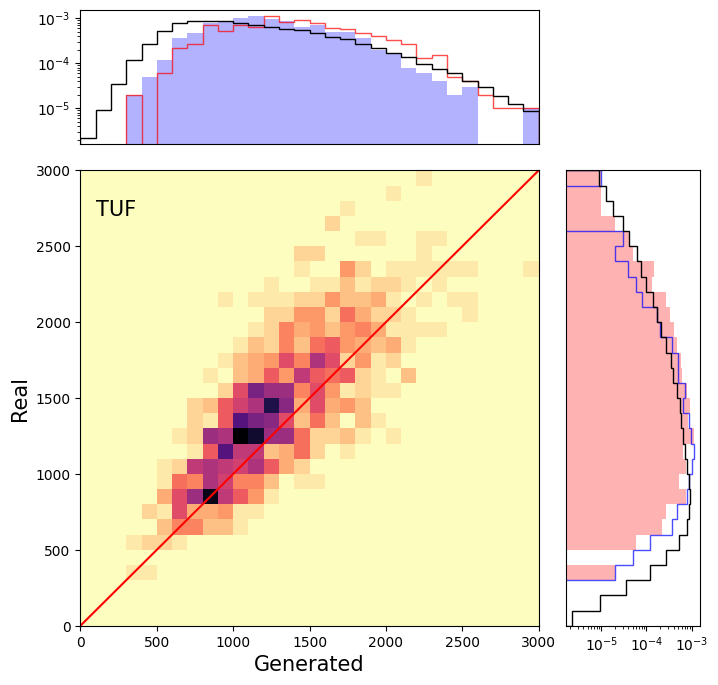

In [37]:
#2D histogram of Generated Image and Real match TUF (Total Unsigned Field)
x = gen_uflux
y = real_uflux
param = 'USFLUX'
ulim = 3000
# Set up the figure
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

# Define the main 2D histogram area
ax_main = fig.add_subplot(grid[1:4, 0:3])
# Define the top marginal histogram
ax_xhist = fig.add_subplot(grid[0, 0:3], sharex=ax_main)
# Define the right marginal histogram
ax_yhist = fig.add_subplot(grid[1:4, 3], sharey=ax_main)

# 2D Histogram
ax_main.hist2d(x, y, bins=30, range=[[0,ulim],[0,ulim]], cmap='magma_r')
ax_main.plot([0,ulim], [0,ulim], '-r')
ax_main.set_xlabel('Generated', fontsize = 15)
ax_main.set_ylabel('Real', fontsize = 15)
ax_main.text(100,0.9*ulim, 'TUF', fontsize = 15)

# Marginal Histograms
ax_xhist.hist(x, bins=30, alpha = 0.3, range=[0, ulim], density=True, color='blue')#ec='blue'
ax_xhist.hist(y, bins=30, range=[0, ulim], alpha=0.7, density=True, color='red', histtype='step')
ax_xhist.hist(df[param].values*128**2, bins=30, range=[0, ulim], density=True, color='k',histtype='step')
ax_xhist.set_yscale('log')
ax_yhist.hist(y, bins=30, alpha = 0.3, range=[0, ulim], density=True, fc='red', color='red', orientation='horizontal')
ax_yhist.hist(x, bins=30, range=[0, ulim], alpha=0.7, density=True, color='blue', histtype='step', orientation='horizontal')
ax_yhist.hist(df[param].values*128**2, bins=30, range=[0, ulim], density=True, color='k',histtype='step', orientation='horizontal')
ax_yhist.set_xscale('log')

# Hide labels on marginal plots
ax_xhist.get_xaxis().set_visible(False)
ax_yhist.get_yaxis().set_visible(False)

# Show the plot
plt.show()

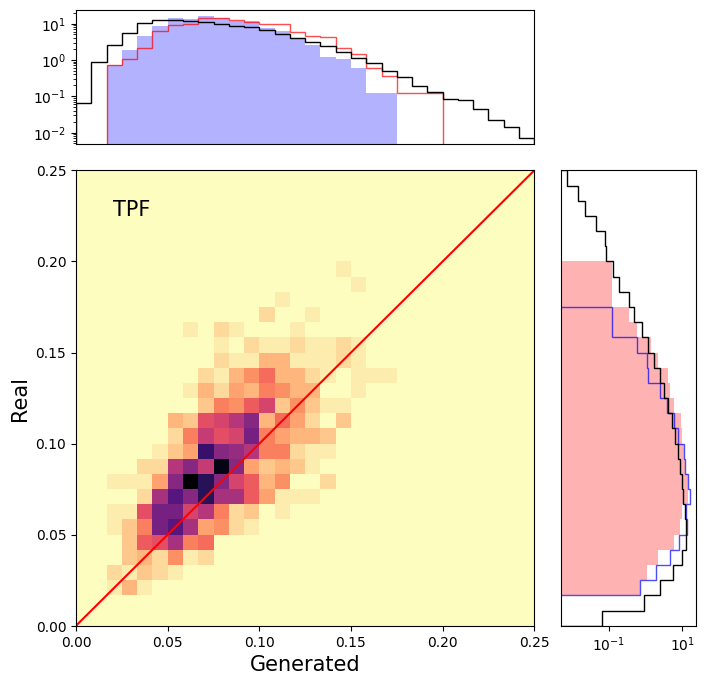

In [39]:
#2D histogram of Generated Image and Real match TPF (Total Positive Field)
x = gen_p
y = real_p
param = 'PFLUX'
ulim = 0.25
# Set up the figure
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

# Define the main 2D histogram area
ax_main = fig.add_subplot(grid[1:4, 0:3])
# Define the top marginal histogram
ax_xhist = fig.add_subplot(grid[0, 0:3], sharex=ax_main)
# Define the right marginal histogram
ax_yhist = fig.add_subplot(grid[1:4, 3], sharey=ax_main)

# 2D Histogram
ax_main.hist2d(x, y, bins=30, range=[[0,ulim],[0,ulim]], cmap='magma_r')
ax_main.plot([0,ulim], [0,ulim], '-r')
ax_main.set_xlabel('Generated', fontsize = 15)
ax_main.set_ylabel('Real', fontsize = 15)
ax_main.text(0.02,0.9*ulim, 'TPF', fontsize = 15)

# Marginal Histograms
ax_xhist.hist(x, bins=30, alpha = 0.3, range=[0, ulim], density=True, color='blue')#ec='blue'
ax_xhist.hist(y, bins=30, range=[0, ulim], alpha=0.7, density=True, color='red', histtype='step')
ax_xhist.hist(df[param].values, bins=30, range=[0, ulim], density=True, color='k',histtype='step')
ax_xhist.set_yscale('log')
ax_yhist.hist(y, bins=30, alpha = 0.3, range=[0, ulim], density=True, fc='red', color='red', orientation='horizontal')
ax_yhist.hist(x, bins=30, range=[0, ulim], alpha=0.7, density=True, color='blue', histtype='step', orientation='horizontal')
ax_yhist.hist(df[param].values, bins=30, range=[0, ulim], density=True, color='k',histtype='step', orientation='horizontal')
ax_yhist.set_xscale('log')

# Hide labels on marginal plots
ax_xhist.get_xaxis().set_visible(False)
ax_yhist.get_yaxis().set_visible(False)

# Show the plot
plt.show()

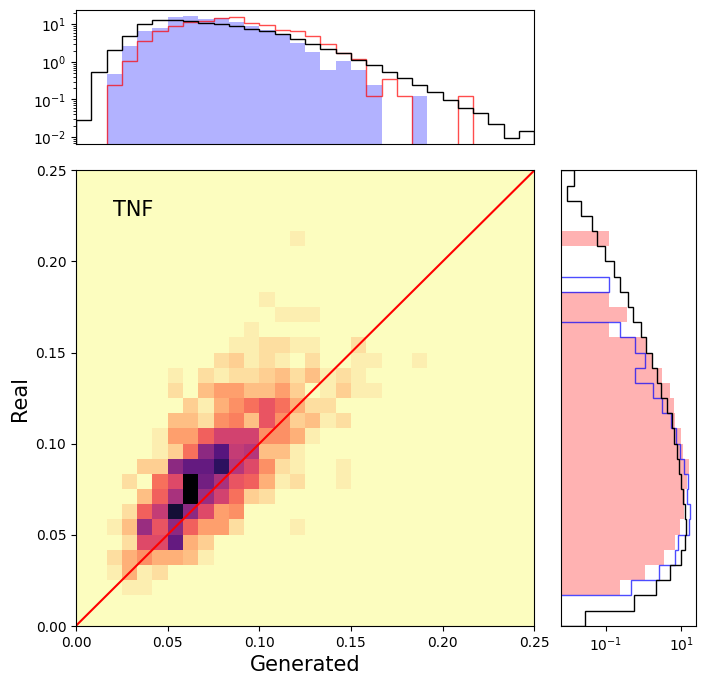

In [40]:
#2D histogram of Generated Image and Real match TNF (Total Negative Field)
x = gen_n
y = real_n
param = 'NFLUX'
ulim = 0.25
# Set up the figure
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

# Define the main 2D histogram area
ax_main = fig.add_subplot(grid[1:4, 0:3])
# Define the top marginal histogram
ax_xhist = fig.add_subplot(grid[0, 0:3], sharex=ax_main)
# Define the right marginal histogram
ax_yhist = fig.add_subplot(grid[1:4, 3], sharey=ax_main)

# 2D Histogram
ax_main.hist2d(x, y, bins=30, range=[[0,ulim],[0,ulim]], cmap='magma_r')
ax_main.plot([0,ulim], [0,ulim], '-r')
ax_main.set_xlabel('Generated', fontsize = 15)
ax_main.set_ylabel('Real', fontsize = 15)
ax_main.text(0.02,0.9*ulim, 'TNF', fontsize = 15)

# Marginal Histograms
ax_xhist.hist(x, bins=30, alpha = 0.3, range=[0, ulim], density=True, color='blue')#ec='blue'
ax_xhist.hist(y, bins=30, range=[0, ulim], alpha=0.7, density=True, color='red', histtype='step')
ax_xhist.hist(df[param].values, bins=30, range=[0, ulim], density=True, color='k',histtype='step')
ax_xhist.set_yscale('log')
ax_yhist.hist(y, bins=30, alpha = 0.3, range=[0, ulim], density=True, fc='red', color='red', orientation='horizontal')
ax_yhist.hist(x, bins=30, range=[0, ulim], alpha=0.7, density=True, color='blue', histtype='step', orientation='horizontal')
ax_yhist.hist(df[param].values, bins=30, range=[0, ulim], density=True, color='k',histtype='step', orientation='horizontal')
ax_yhist.set_xscale('log')

# Hide labels on marginal plots
ax_xhist.get_xaxis().set_visible(False)
ax_yhist.get_yaxis().set_visible(False)

# Show the plot
plt.show()

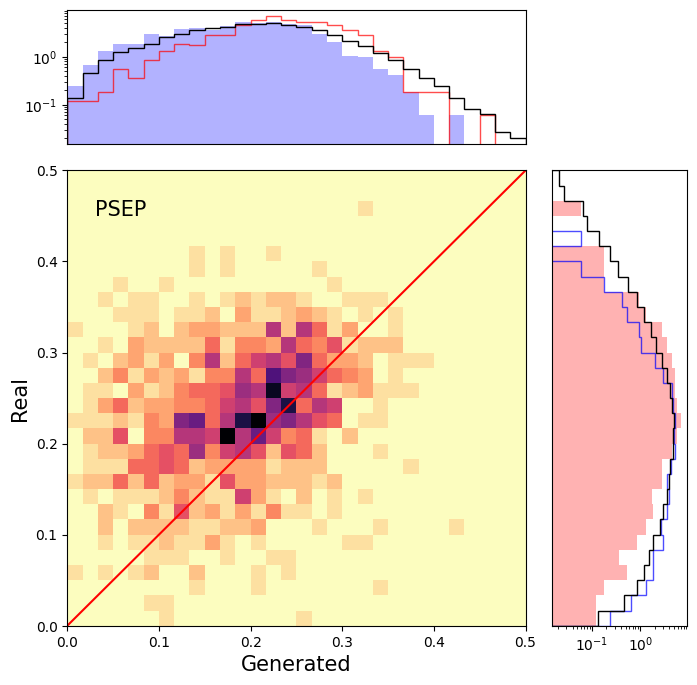

In [41]:
#2D histogram of Generated Image and Real match PSEP
x = gen_d
y = real_d
param = 'PSEP'
# Set up the figure
fig = plt.figure(figsize=(8, 8))
grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)

# Define the main 2D histogram area
ax_main = fig.add_subplot(grid[1:4, 0:3])
# Define the top marginal histogram
ax_xhist = fig.add_subplot(grid[0, 0:3], sharex=ax_main)
# Define the right marginal histogram
ax_yhist = fig.add_subplot(grid[1:4, 3], sharey=ax_main)

# 2D Histogram
ax_main.hist2d(x, y, bins=30, range=[[0,0.5],[0,0.5]], cmap='magma_r')
ax_main.plot([0,0.5], [0,0.5], '-r')
ax_main.set_xlabel('Generated', fontsize = 15)
ax_main.set_ylabel('Real', fontsize = 15)
ax_main.text(0.03,0.9*0.5, 'PSEP', fontsize = 15)
# Marginal Histograms
ax_xhist.hist(x, bins=30, alpha = 0.3, range=[0, 0.5], density=True, color='blue')#ec='blue'
ax_xhist.hist(y, bins=30, range=[0, 0.5], alpha=0.7, density=True, color='red', histtype='step')
ax_xhist.hist(df[param].values, bins=30, range=[0, 0.5], density=True, color='k',histtype='step')
ax_xhist.set_yscale('log')
ax_yhist.hist(y, bins=30, alpha = 0.3, range=[0, 0.5], density=True, fc='red', color='red', orientation='horizontal')
ax_yhist.hist(x, bins=30, range=[0, 0.5], alpha=0.7, density=True, color='blue', histtype='step', orientation='horizontal')
ax_yhist.hist(df[param].values, bins=30, range=[0, 0.5], density=True, color='k',histtype='step', orientation='horizontal')
ax_yhist.set_xscale('log')

# Hide labels on marginal plots
ax_xhist.get_xaxis().set_visible(False)
ax_yhist.get_yaxis().set_visible(False)

# Show the plot
plt.show()